# Building a Regression Model for a Financial Dataset

In this notebook, you will build a simple linear regression model to predict the closing AAPL stock price. The lab objectives are:
* Pull data from BigQuery into a Pandas dataframe
* Use Matplotlib to visualize data
* Use Scikit-Learn to build a regression model

Kindly ignore the deprecation warnings and incompatibility errors related to google-cloud-storage.

In [12]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.rc('figure', figsize=(12, 8.0))

## Pull Data from BigQuery

In this section we'll use a magic function to query a BigQuery table and then store the output in a Pandas dataframe. A magic function is just an alias to perform a system command. To see documentation on the "bigquery" magic function execute the following cell:

The query below selects everything you'll need to build a regression model to predict the closing price of AAPL stock. The model will be very simple for the purposes of demonstrating BQML functionality. The only features you'll use as input into the model are the previous day's closing price and a three day trend value. The trend value can only take on two values, either -1 or +1. If the AAPL stock price has increased over any two of the previous three days then the trend will be +1. Otherwise, the trend value will be -1.

Note, the features you'll need can be generated from the raw table `ai4f.AAPL10Y` using Pandas functions. However, it's better to take advantage of the serverless-ness of BigQuery to do the data pre-processing rather than applying the necessary transformations locally.

In [13]:
df = pd.read_csv("data/AAPL10Y.csv")

In [14]:
raw = df[['date','close']]

raw['min_1_close'] = df['close'].shift(1)
raw['min_2_close'] = df['close'].shift(2)
raw['min_3_close'] = df['close'].shift(3)
raw['min_4_close'] = df['close'].shift(4)

C:\Users\1\AppData\Local\Temp\ipykernel_26164\2330829310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['min_1_close'] = df['close'].shift(1)
C:\Users\1\AppData\Local\Temp\ipykernel_26164\2330829310.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['min_2_close'] = df['close'].shift(2)
C:\Users\1\AppData\Local\Temp\ipykernel_26164\2330829310.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [15]:
raw = raw.dropna().sort_values('date', ascending=False)

In [16]:
raw

,date,close,min_1_close,min_2_close,min_3_close,min_4_close
4,2019/05/28,178.2300,177.3800,178.3000,175.0700,173.3000
5,2019/05/24,178.9700,178.2300,177.3800,178.3000,175.0700
6,2019/05/23,179.6600,178.9700,178.2300,177.3800,178.3000
7,2019/05/22,182.7800,179.6600,178.9700,178.2300,177.3800
8,2019/05/21,186.6000,182.7800,179.6600,178.9700,178.2300
...,...,...,...,...,...,...
2512,2009/06/09,20.3886,20.0357,19.9929,19.5671,19.4414
2513,2009/06/08,20.5500,20.3886,20.0357,19.9929,19.5671
2514,2009/06/05,20.6671,20.5500,20.3886,20.0357,19.9929
2515,2009/06/04,20.5343,20.6671,20.5500,20.3886,20.0357


In [17]:
raw_plus_trend = raw[['date', 'close', 'min_1_close']]
raw_plus_trend['min_1_trend'] = pd.DataFrame(list(map(lambda i: 1 if i >0 else -1 , raw['min_1_close'] - raw['min_2_close'])))

raw_plus_trend['min_2_trend'] = pd.DataFrame(list(map(lambda i: 1 if i >0 else -1 , raw['min_2_close'] - raw['min_3_close'])))

raw_plus_trend['min_3_trend'] = pd.DataFrame(list(map(lambda i: 1 if i >0 else -1 , raw['min_3_close'] - raw['min_4_close'])))

raw_plus_trend = raw_plus_trend.sort_values('date')

C:\Users\1\AppData\Local\Temp\ipykernel_26164\3088330228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_plus_trend['min_1_trend'] = pd.DataFrame(list(map(lambda i: 1 if i >0 else -1 , raw['min_1_close'] - raw['min_2_close'])))
C:\Users\1\AppData\Local\Temp\ipykernel_26164\3088330228.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_plus_trend['min_2_trend'] = pd.DataFrame(list(map(lambda i: 1 if i >0 else -1 , raw['min_2_close'] - raw['min_3_close'])))


In [18]:
raw_plus_trend

,date,close,min_1_close,min_1_trend,min_2_trend,min_3_trend
2516,2009/06/03,20.1357,20.5343,NaN,NaN,NaN
2515,2009/06/04,20.5343,20.6671,NaN,NaN,NaN
2514,2009/06/05,20.6671,20.5500,NaN,NaN,NaN
2513,2009/06/08,20.5500,20.3886,NaN,NaN,NaN
2512,2009/06/09,20.3886,20.0357,-1.0,1.0,1.0
...,...,...,...,...,...,...
8,2019/05/21,186.6000,182.7800,1.0,1.0,-1.0
7,2019/05/22,182.7800,179.6600,1.0,-1.0,1.0
6,2019/05/23,179.6600,178.9700,-1.0,1.0,1.0
5,2019/05/24,178.9700,178.2300,1.0,1.0,1.0


In [20]:
data = raw_plus_trend[['date','close','min_1_close']]

data['trend_3_day'] = pd.DataFrame(list(map(lambda i: 1 if i >0 else -1 , raw_plus_trend['min_1_trend'] + raw_plus_trend['min_2_trend'] + raw_plus_trend['min_3_trend'])))

data = data.sort_values('date')

C:\Users\1\AppData\Local\Temp\ipykernel_26164\870581348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['trend_3_day'] = pd.DataFrame(list(map(lambda i: 1 if i >0 else -1 , raw_plus_trend['min_1_trend'] + raw_plus_trend['min_2_trend'] + raw_plus_trend['min_3_trend'])))


In [21]:
data

,date,close,min_1_close,trend_3_day
2516,2009/06/03,20.1357,20.5343,NaN
2515,2009/06/04,20.5343,20.6671,NaN
2514,2009/06/05,20.6671,20.5500,NaN
2513,2009/06/08,20.5500,20.3886,NaN
2512,2009/06/09,20.3886,20.0357,1.0
...,...,...,...,...
8,2019/05/21,186.6000,182.7800,1.0
7,2019/05/22,182.7800,179.6600,1.0
6,2019/05/23,179.6600,178.9700,1.0
5,2019/05/24,178.9700,178.2300,1.0


View the first five rows of the query's output. Note that the object `df` containing the query output is a Pandas Dataframe.

In [23]:
print(type(data))
data.dropna(inplace=True)
data.head()

<class 'pandas.core.frame.DataFrame'>


,date,close,min_1_close,trend_3_day
2512,2009/06/09,20.3886,20.0357,1.0
2511,2009/06/10,20.0357,19.9929,1.0
2510,2009/06/11,19.9929,19.5671,1.0
2509,2009/06/12,19.5671,19.4414,1.0
2508,2009/06/15,19.4414,19.4786,1.0


## Visualize data

The simplest plot you can make is to show the closing stock price as a time series. Pandas DataFrames have built in plotting funtionality based on Matplotlib. 

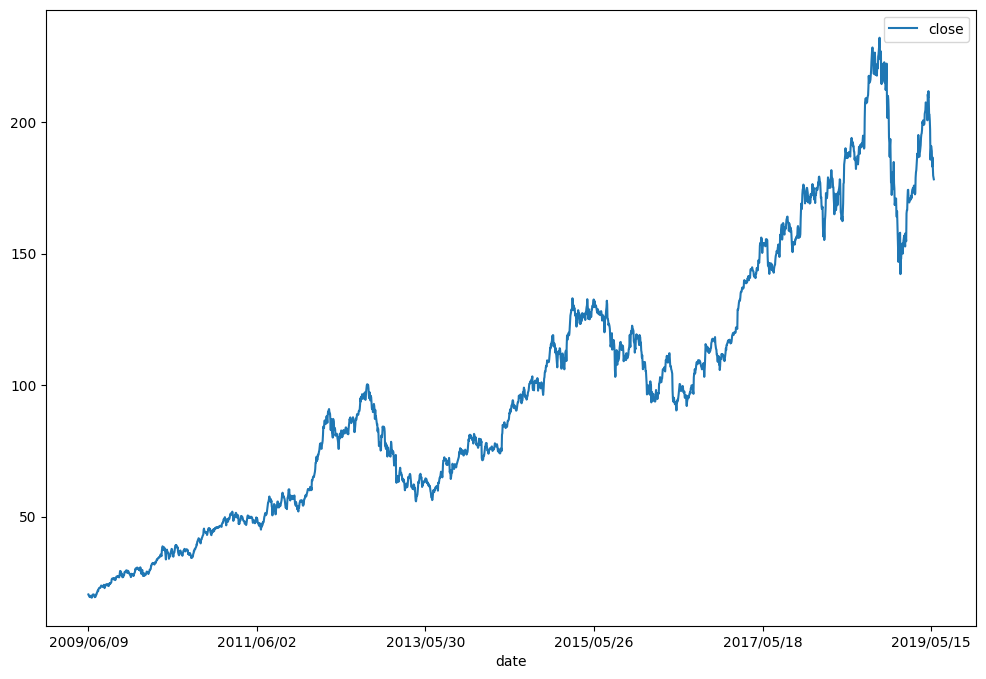

In [24]:
data.plot(x='date', y='close');

You can also embed the `trend_3_day` variable into the time series above. 

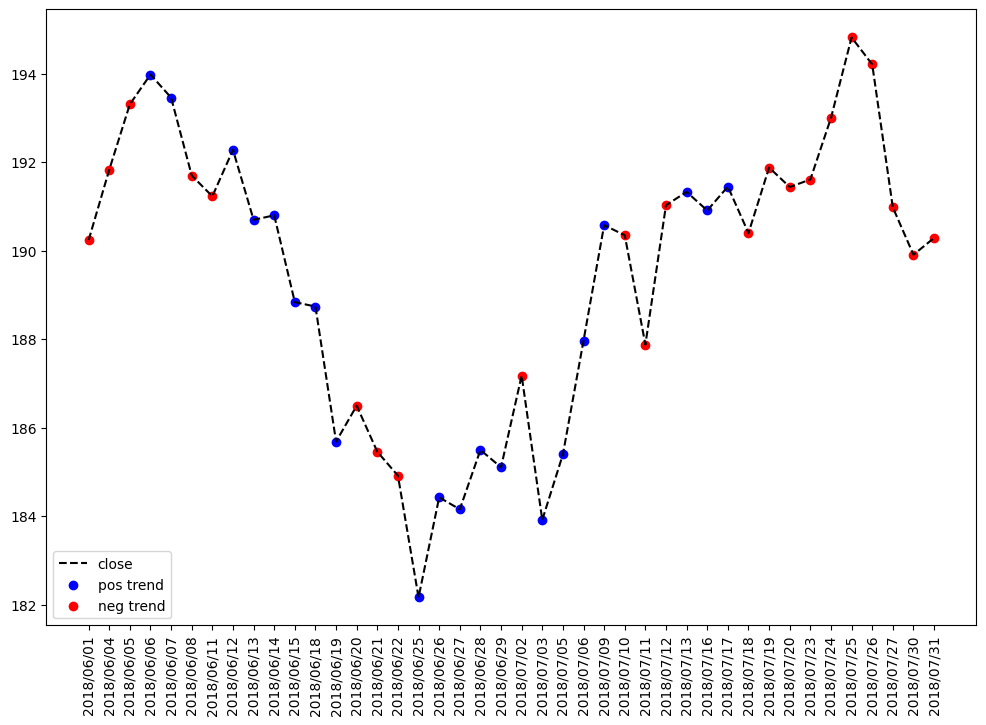

In [25]:
start_date = '2018-06-01'
end_date = '2018-07-31'

plt.plot(
    'date', 'close', 'k--',
    data = (
        data.loc[pd.to_datetime(data.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='b', label='pos trend', 
    data = (
        data.loc[data.trend_3_day == 1 & pd.to_datetime(data.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='r', label='neg trend',
    data = (
        data.loc[(data.trend_3_day == -1) & pd.to_datetime(data.date).between(start_date, end_date)]
    )
)

plt.legend()
plt.xticks(rotation = 90);

In [26]:
df.shape

(2517, 6)

## Build a Regression Model in Scikit-Learn

In this section you'll train a linear regression model to predict AAPL closing prices when given the previous day's closing price `day_prev_close` and the three day trend `trend_3_day`. A training set and test set are created by sequentially splitting the data after 2000 rows. 

In [27]:
features = ['min_1_close', 'trend_3_day']
target = 'close'

X_train, X_test = data.loc[:2000, features], data.loc[2000:, features]
y_train, y_test = data.loc[:2000, target], data.loc[2000:, target]

In [28]:
lin_reg = sklearn.linear_model.LinearRegression(fit_intercept=False)

In [29]:
lin_reg.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [30]:
pred = lin_reg.predict(X_test)

In [31]:
import math
rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_test, pred))
print(rmse)

1.9710787065928916


In [32]:
var = sklearn.metrics.explained_variance_score(y_test,pred)
print(var)

0.998025559570231


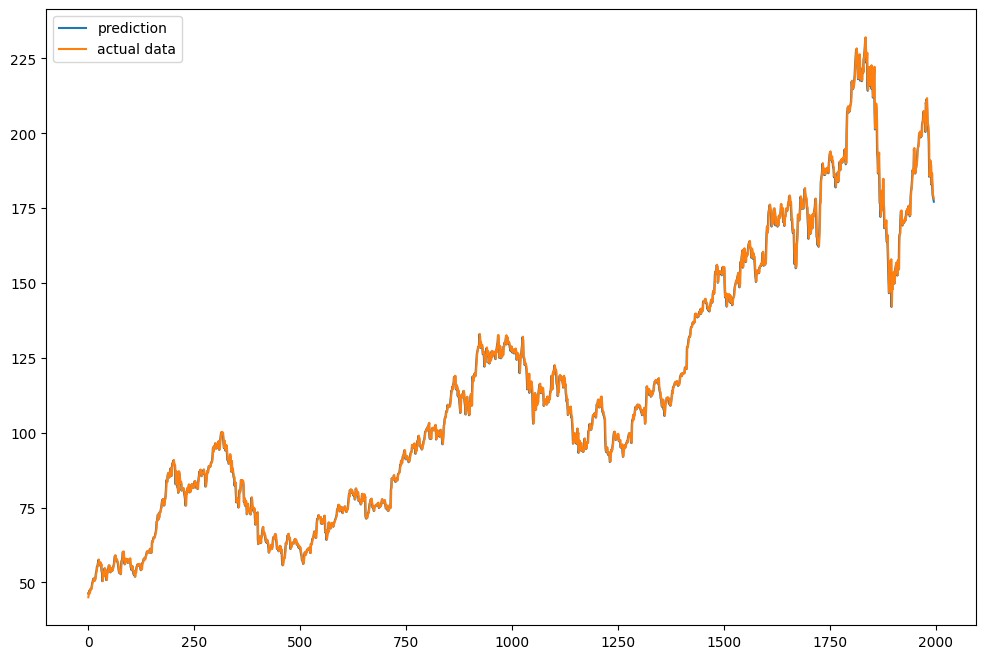

In [33]:
plt.plot(pred, label = 'prediction')
plt.plot(y_test.values, label = 'actual data')
plt.legend()

The model's predictions are more or less in line with the truth. However, the utility of the model depends on the business context (i.e. you won't be making any money with this model). It's fair to question whether the variable `trend_3_day` even adds to the performance of the model:

In [34]:
print('Root Mean Squared Error: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, X_test.min_1_close))))

Root Mean Squared Error: 1.97


Indeed, the RMSE is actually lower if we simply use the previous day's closing value as a prediction! Does increasing the number of days included in the trend improve the model? Feel free to create new features and attempt to improve model performance!